In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2

In [2]:
def scale(img, nR, nC):
    height = img.shape[0]     # source number of rows 
    width = img.shape[1]  # source number of columns 
    return np.array([[img[int(height * r / nR)][int(width * c / nC)]  for c in range(nC)] for r in range(nR)])

In [3]:
def loadImages(path):
    images = []
    for i in range(1,19):
        img = plt.imread(path+'/image'+str(i)+'.png')
        # Converting the image to gray scale
        R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
        img = 0.2989 * R + 0.5870 * G + 0.1140 * B
        img = scale(img, 800, 1000)
        img = np.float32(img)
        images.append(img)

    return images

In [4]:
def gaussian2d(x,y,sigma):
    """Function for calculating the 2-dimensional gaussian"""
    x2 = x**2
    y2 = y**2
    sigma2 = sigma**2
    # Return the value of 2-dimensional gaussian value with the given point x, y
    return (1/(2*np.pi*sigma2))*np.exp(-1*((x2+y2)/(2*sigma2)))

In [5]:
def get_gaussian_kernel(size, sigma=None):
    """
    Getting the gaussian kernel
    The effcient size for the gaussian kernel is the smallest odd number that is larger than 6*sigma     
    """
    # Calculating the best sigma for the given size
    if sigma == None:
        sigma = 0.3 * (size // 2) + 0.8
    # Getting the range of x, y
    aran = np.arange(-1 * (size // 2), size // 2 + 1)
    XX, YY = np.meshgrid(aran, aran)
    # making the kernel
    kernel = gaussian2d(XX, YY, sigma)
    #normaliing
    kernel = kernel/np.sum(kernel)
    return kernel

In [6]:
def filter(weights,roi):
    weights = weights.astype('float')
    roi = roi.astype('float')
    # this holds the end result
    filtered = np.zeros_like(roi)
    width = int((weights.shape[1]-1)/2)
    height = int((weights.shape[0]-1)/2)

    # convolution
    for i in range(height,roi.shape[1]-height):
        for j in range(width,roi.shape[0]-width):
            filtered[j,i]= np.sum(weights * roi[j-width:j+width+1, i-height:i+height+1])
    
    return filtered

In [7]:
def getFeaturePoints(img, winSize=7, threshold=0.15):
    h, w = img.shape[:2]
    # Doing the derivatives
    filter_sobelx = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
    ])
    I_x=filter(filter_sobelx, img)

    filter_sobely = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    I_y=filter(filter_sobely, img)

    g_kernel = get_gaussian_kernel(winSize)

    # Making the matrix H for each pixel
    H = np.zeros((h,w,2,2))
    H[:, :, 0, 0] = filter(g_kernel, np.square(I_x))
    H[:, :, 0, 1] = filter(g_kernel, I_x*I_y)
    H[:, :, 1, 0] = filter(g_kernel, I_x*I_y)
    H[:, :, 1, 1] = filter(g_kernel, np.square(I_y))

    # Making a matrix for holding the values for corner_strength
    corner_strength = np.zeros((h,w))

    coords = []

    # usually the value 0.04 is the optimal value
    k = 0.04
    for idx_h in range(h):
        for idx_w in range(w):
            det = np.linalg.det(H[idx_h, idx_w, :, :])
            tr = np.trace(H[idx_h, idx_w, :, :])
            harris = det - (k*(tr**2))
            corner_strength[idx_h, idx_w] = harris

            # if harris >= threshold:
            #     coords.append((idx_h, idx_w))

    for idx_h in range(1, h):
        for idx_w in range(1, w):
            local_window = corner_strength[idx_h-1:idx_h+2, idx_w-1:idx_w+2]
            maxima = np.amax(local_window)
            if local_window[1,1] == maxima and local_window[1,1] >= threshold:
                coords.append((idx_h, idx_w))

    coords = list(set(coords))
    
    fig, ax = plt.subplots()

    ax.imshow(img,cmap="gray")
    
    # Plotting the circle
    for blob in coords:
        y, x = blob
        c = plt.Circle((x, y), 2, linewidth=1.5 ,color='red', fill=False)
        ax.add_patch(c)
    ax.plot()  
    plt.show()

    return coords

In [8]:
def get_grad(x, y, image):
    filter_sobelx = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
    ])
    filter_sobely = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    
    local_window = image[y-1:y+2, x-1:x+2]

    dx = np.sum(filter_sobelx * local_window)
    dy = np.sum(filter_sobely * local_window)

    return cart_to_poloar_grad(dx, dy)

In [9]:
def cart_to_poloar_grad(dx, dy):
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dx, dy)+np.pi) * 180/np.pi

    return m, theta

In [10]:
def orientation(kps, image):
    new_kps = []
    bin_width = 360//36

    for kp in kps:
        y, x = int(kp[0]), int(kp[1])
        hist = np.zeros(36, dtype=np.float32)

        m, theta = get_grad(x, y, image)

        bin = int(np.floor(theta)//bin_width)

        hist[bin] += m

        max_bin = np.argmax(hist)
        new_kps.append([kp[0],kp[1],max_bin])

    return np.array(new_kps)

In [11]:
def get_patch_grads(p):
    # # Doing the derivatives
    filter_sobelx = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
    ])
    dx=filter(1/8*filter_sobelx, p)

    filter_sobely = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    dy=filter(1/8*filter_sobely, p)

    return dx, dy

In [12]:
def get_subregion_hist(m, theta, reference_angle, bin_width, subregion):
    hist = np.zeros(8, dtype=np.float32)

    for mag, angle in zip(m, theta):
        angle = (angle-reference_angle) % 360
        angle = 359 if (angle >=360) else angle
        binno = int(np.floor(angle)//bin_width)
        hist[binno] += mag

    return hist

In [13]:
def getFeatureDescriptors(kps, size, image, num_subregion=4):
    
    keypoints = orientation(kps, image)

    descs = []
    bin_width = 360//8

    for kp in keypoints:
        cx, cy = int(kp[0]), int(kp[1])
        t, l = cy-(size//2), cx-(size//2)
        b, r = cy+(size//2)+1 , cx+(size//2)+1
        patch = image[t:b, l:r]
        dx, dy = get_patch_grads(patch)

        m, theta = cart_to_poloar_grad(dx, dy)

        subregion = size//num_subregion
        feature_vec = np.zeros(8 * num_subregion**2, dtype=np.float32)

        for i in range(0, subregion):
            for j in range(0, subregion):
                t, l = i*subregion, j*subregion
                b, r = (i+1)*subregion, (j+1)*subregion
                hist = get_subregion_hist(m[t:b, l:r].ravel(), theta[t:b, l:r].ravel(), kp[2], bin_width, subregion)

                feature_vec[i*subregion*8 + j*8:i*subregion*8 + (j+1)*8] = hist.flatten()

        descs.append(feature_vec)

    return np.array(descs)


In [14]:
def match2Images(feat_p1, feat_p2, feat_vec1, feat_vec2, image1, image2, threshold=0.2):
    match = []

    for p1_idx, p1 in enumerate(feat_vec1):
        distances = []
        for p2_idx, p2 in enumerate(feat_vec2):
            dist = np.sum(np.square(p1-p2))
            distances.append((p1_idx, p2_idx, dist))
        
        distances = sorted(distances, key=lambda x: x[2])
        
        first = distances[0][2]
        second = distances[1][2]

        ratio = first/second

        if ratio < threshold:
            point1 = feat_p1[distances[0][0]]
            point2 = feat_p2[distances[0][1]]
            match.append((point1, point2))


    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.imshow(image1, cmap='gray')
    ax2.imshow(image2, cmap='gray')

    for point1, point2 in match:
        p1y, p1x = point1
        p2y, p2x = point2

        con = mpl.patches.ConnectionPatch(xyA=(p1x,p1y), xyB=(p2x,p2y), coordsA='data', coordsB='data', axesA=ax1, axesB=ax2, color='red')

        ax2.add_artist(con)

        ax1.plot(p1x, p1y,'ro', markersize=1)
        ax2.plot(p2x, p2y,'ro', markersize=1)

    plt.show()

    return match

In [15]:
images = loadImages('./images')

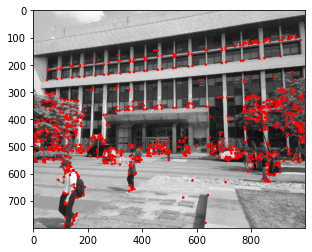

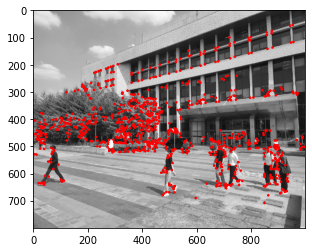

In [16]:
img1_corner = getFeaturePoints(images[0])
img2_corner = getFeaturePoints(images[1])

In [17]:
ex1 = getFeatureDescriptors(img1_corner, 16, images[0])
ex2 = getFeatureDescriptors(img2_corner, 16, images[1])

/tmp/ipykernel_2440/932866076.py:15: RuntimeWarning: invalid value encountered in float_scalars
  ratio = first/second


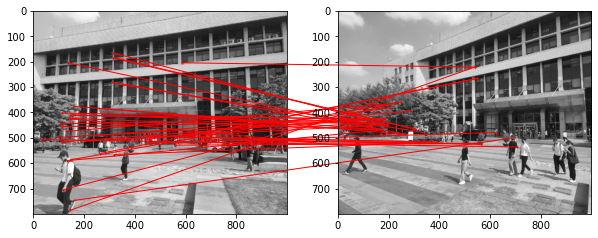

In [19]:
mp = match2Images(img1_corner, img2_corner, ex1, ex2, images[0], images[1], threshold=0.6)